In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import pymc3 as pm
import glob
import theano.tensor as tt
import theano as th
from scipy.stats import poisson, nbinom

/home/slee/.pyenv/versions/anaconda3-4.3.1/envs/gatk-dev/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
panel_count_files = sorted(glob.glob('panel/*hdf5'))
cases_count_files = sorted(glob.glob('cases/*hdf5'))
count_files = np.concatenate([panel_count_files, cases_count_files])

In [4]:
num_samples = len(count_files)
num_contigs = 24
min_count = 0
max_count = 250
count_states = np.arange(min_count, max_count + 1)
num_count_states = len(count_states)

hist_sjm = np.zeros((num_samples, num_contigs, num_count_states), dtype=int)  #occurrence per sample, contig, count
for sample_index, count_file in enumerate(count_files[:num_samples]):
    count_hdf5 = h5py.File(count_file, 'r')
    contig_indices = count_hdf5['intervals']['transposed_index_start_end'][0, :].astype(int)
    counts = count_hdf5['counts']['values'][0, :].astype(int)
    contig_lengths = np.bincount(contig_indices)
    split_indices = np.cumsum(contig_lengths)[:-1]
    counts_per_contig = np.split(counts, split_indices)[-num_contigs:]
    hists_per_contig = [np.histogram(counts, bins=range(min_count, max_count + 2))[0] 
                        for counts in counts_per_contig]
    hist_sjm[sample_index] = hists_per_contig

In [5]:
def construct_mask(hist_sjm):
    mode_sj = np.argmax(hist_sjm * (count_states >= 5), axis=2)
    mask_sjm = np.full(np.shape(hist_sjm), False)
    for s in range(np.shape(hist_sjm)[0]):
        for j in range(np.shape(hist_sjm)[1]):
            min_sj = np.argmin(hist_sjm[s, j, :mode_sj[s, j]])
            if mode_sj[s, j] <= 10:
                mode_sj[s, j] = 0
                cutoff = 0.
            else:
                cutoff = 0.05
            for m in range(mode_sj[s, j], np.shape(hist_sjm)[2]):
                if hist_sjm[s, j, m] >= cutoff * hist_sjm[s, j, mode_sj[s, j]]:
                    if hist_sjm[s, j, m] >= 0:
                        mask_sjm[s, j, m] = True
                else:
                    break
            for m in range(mode_sj[s, j], min_sj, -1):
                if hist_sjm[s, j, m] >= cutoff * hist_sjm[s, j, mode_sj[s, j]]:
                    if hist_sjm[s, j, m] >= 0:
                        mask_sjm[s, j, m] = True
                else:
                    break
        mask_sjm[:, :, 0] = False
    return mask_sjm, mode_sj

In [6]:
# mask_sjm, mode_sj = construct_mask(hist_sjm)
# for sample_index in range(num_samples):
#     print('sample', sample_index, count_files[sample_index], mode_sj[sample_index])
#     for contig_index in range(num_contigs):
#         hist_m_masked = hist_sjm[sample_index, contig_index][mask_sjm[sample_index, contig_index]]
#         num_occurrences_tot = sum(hist_m_masked)
#         plt.semilogy(hist_sjm[sample_index, contig_index], color='b', lw=0.5)
#         plt.semilogy(count_states[mask_sjm[sample_index, contig_index]], hist_m_masked, color='r', lw=2)
#         plt.ylim([1, 1.5 * np.max(hist_sjm[sample_index, contig_index])])
#     plt.show()

In [7]:
eps = 1E-10
ploidy_concentration_scale = 0.1

contig_sets = []
for j in range(num_contigs)[:-2]:
    contig_sets.append([j])
contig_sets.append([num_contigs - 2, num_contigs - 1])

num_contig_sets = len(contig_sets)

ploidy_states_ik = []
ploidy_priors_ik_unnorm = []
for contig_set in contig_sets[:-1]:
    ploidy_states_ik.append([[2]])
    ploidy_priors_ik_unnorm.append(np.array([1.]))
ploidy_states_ik.append([[2, 0], [1, 1], [1, 0], [3, 0], [1, 2], [2, 1]])
ploidy_priors_ik_unnorm.append(np.array([1., 1., 0.02, 0.02, 0.02, 0.02]))

ploidy_priors_ik_unnorm = np.array(ploidy_priors_ik_unnorm)
ploidy_priors_ik = [(ploidy_priors_ik_unnorm[i] + eps) / np.sum(ploidy_priors_ik_unnorm[i] + eps)
                    for i in range(num_contig_sets)]

ploidy_jk = []
for i, contig_set in enumerate(contig_sets):
    for j_index, j in enumerate(contig_set):
        ploidy_jk.append(np.array([ploidy_state[j_index] for ploidy_state in ploidy_states_ik[i]]))

In [8]:
with pm.Model() as model:
    mask_sjm, _ = construct_mask(hist_sjm)

    d_s = pm.Uniform('d_s', upper=1000., shape=num_samples, testval=40.)

    b_j = pm.Bound(pm.Gamma, lower=0.8, upper=1.2)('b_j', alpha=100, beta=100, shape=num_contigs)
    b_j_norm = pm.Deterministic('b_j_norm', var=b_j / tt.mean(b_j))

    f_js = pm.Bound(pm.Normal, lower=-0.9, upper=0.5)('f_js', sd=0.01, shape=(num_contigs, num_samples))

    pi_i_sk = [pm.Dirichlet('pi_%d_sk' % i, a=ploidy_concentration_scale * ploidy_priors_ik[i], 
                           shape=(num_samples, len(ploidy_states_ik[i])), 
                           transform=pm.distributions.transforms.t_stick_breaking(eps))
                if len(contig_set) > 1 else pm.Deterministic('pi_%d_sk' % i, var=tt.ones((num_samples, 1)))
               for i, contig_set in enumerate(contig_sets)]

    e_js = pm.Uniform('e_js', lower=0., upper=0.1, shape=(num_contigs, num_samples))

    mu_j_sk = [d_s.dimshuffle(0, 'x') * b_j_norm[j] * \
                (tt.maximum(ploidy_jk[j][np.newaxis, :] + f_js[j].dimshuffle(0, 'x') * (ploidy_jk[j][np.newaxis, :] > 0),
                            e_js[j].dimshuffle(0, 'x')))
               for j in range(num_contigs)]
    alpha_js = pm.Uniform('alpha_js', upper=10000., shape=(num_contigs, num_samples))
    p_j_skm = [tt.exp(pm.NegativeBinomial.dist(mu=mu_j_sk[j].dimshuffle(0, 1, 'x') + eps,
                                               alpha=alpha_js[j].dimshuffle(0, 'x', 'x'))
                    .logp(tt.arange(min_count, max_count + 1).dimshuffle('x', 'x', 0)))
               for j in range(num_contigs)]

    def _logp_sjm(_hist_sjm):
        num_occurrences_tot_sj = tt.sum(_hist_sjm * mask_sjm, axis=2)
        logp_j_skm = [pm.Poisson.dist(mu=num_occurrences_tot_sj[:, j].dimshuffle(0, 'x', 'x') * p_j_skm[j] + eps) \
                          .logp(_hist_sjm[:, j, :].dimshuffle(0, 'x', 1))
                      for j in range(num_contigs)]
        return tt.sum(
            [pm.math.logsumexp(
                mask_sjm[:, j, np.newaxis, :] * (tt.log(pi_i_sk[i][:, :, np.newaxis] + eps) + logp_j_skm[j]),
                axis=1) 
             for i, contig_set in enumerate(contig_sets) for j in contig_set])

    pm.DensityDist(name='hist_sjm', logp=_logp_sjm, observed=hist_sjm)

In [9]:
def fit(inference, n=1000, learning_rate=5E-2):
    approx = inference.fit(n=n, obj_optimizer=pm.adamax(learning_rate=learning_rate))
    return inference, approx, approx.hist

with model:
    inference = pm.ADVI(random_seed=1)
    
elbos = np.array([])

In [10]:
for i in range(5):
    %time inference, approx, elbos = fit(inference, n=500, learning_rate=5E-2)

Average Loss = 3.7099e+08: 100%|██████████| 500/500 [00:41<00:00, 11.93it/s]
Finished [100%]: Average Loss = 3.6553e+08


CPU times: user 2min, sys: 440 ms, total: 2min 1s
Wall time: 2min 1s


Average Loss = 1.5459e+07: 100%|██████████| 500/500 [00:41<00:00, 11.95it/s]
Finished [100%]: Average Loss = 1.5286e+07


CPU times: user 2min 1s, sys: 364 ms, total: 2min 1s
Wall time: 2min 2s


Average Loss = 2.3553e+06: 100%|██████████| 500/500 [00:41<00:00, 12.01it/s]
Finished [100%]: Average Loss = 2.3392e+06


CPU times: user 2min 3s, sys: 412 ms, total: 2min 3s
Wall time: 2min 3s


Average Loss = 1.0789e+06: 100%|██████████| 500/500 [00:41<00:00, 11.96it/s]
Finished [100%]: Average Loss = 1.0747e+06


CPU times: user 2min 3s, sys: 328 ms, total: 2min 3s
Wall time: 2min 4s


Average Loss = 8.5097e+05: 100%|██████████| 500/500 [00:41<00:00, 12.00it/s]
Finished [100%]: Average Loss = 8.4862e+05


CPU times: user 2min, sys: 512 ms, total: 2min 1s
Wall time: 2min 1s


710584.1302462905


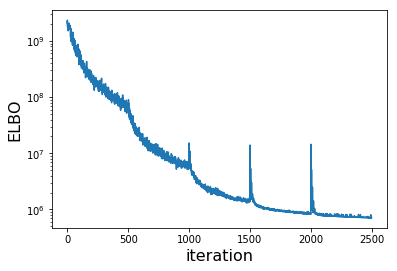

In [11]:
print(elbos[-1])
plt.semilogy(elbos)
plt.xlabel('iteration', size=16)
plt.ylabel('ELBO', size=16)
plt.show()

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '4625' (I am process '5849')


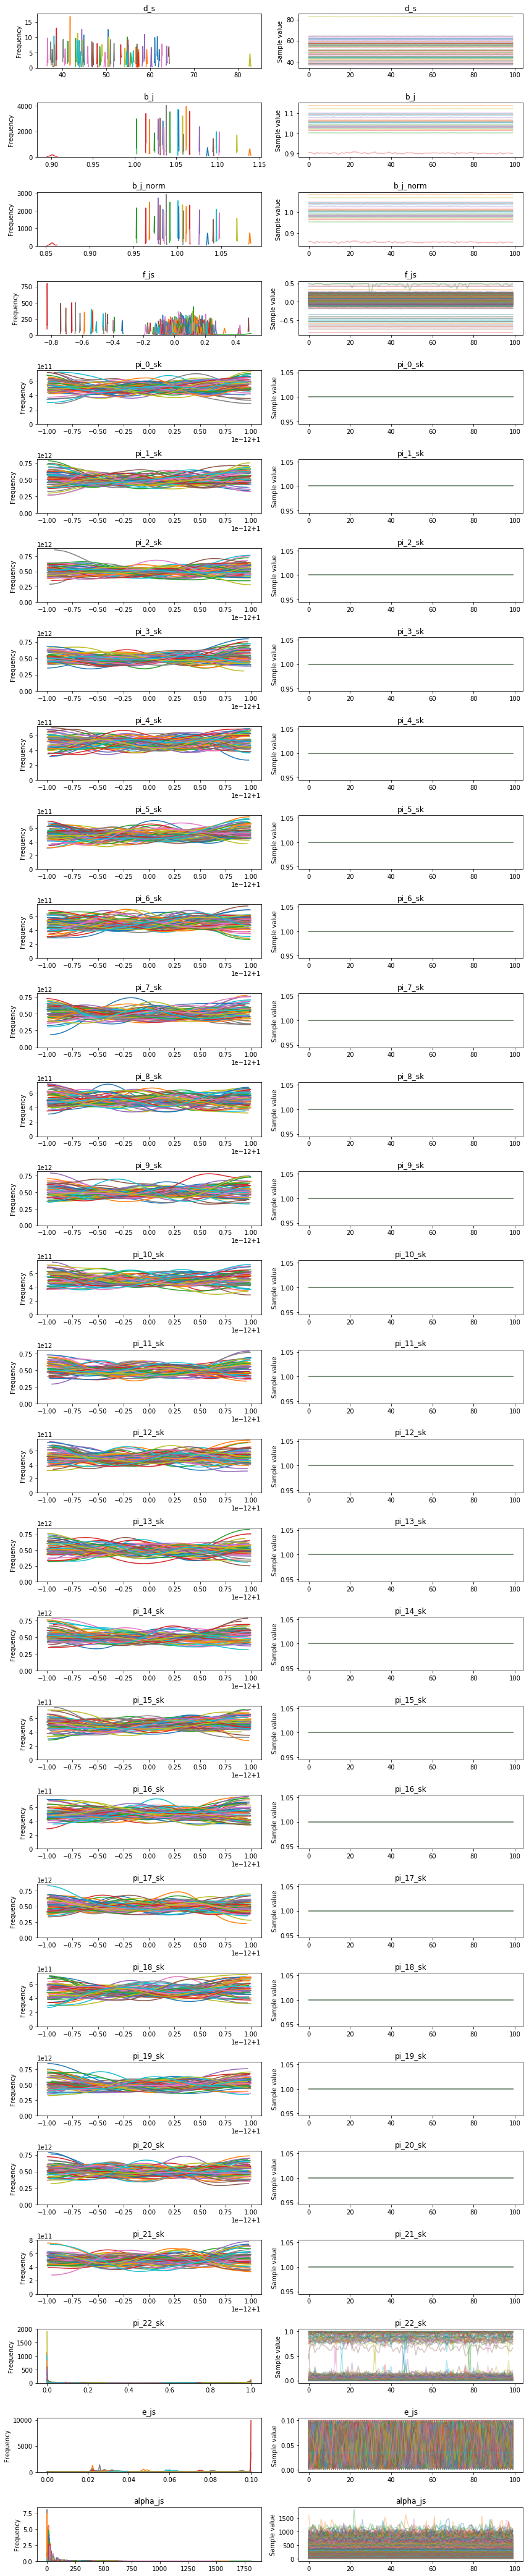

In [12]:
trace = approx.sample(draws=100)
pm.plots.traceplot(trace)
plt.show()

In [13]:
def convert_params(mu, var):
    n = mu**2 / (var - mu)
    p = 1 - (var - mu) / var
    return n, p

d_s_tr = np.mean(trace['d_s'], axis=0)
b_j_tr = np.mean(trace['b_j_norm'], axis=0)
f_js_tr = np.mean(trace['f_js'], axis=0)
e_js_tr = np.mean(trace['e_js'], axis=0)
alpha_js_tr = np.mean(trace['alpha_js'], axis=0)
pi_jsk_tr = [np.mean(trace['pi_%d_sk' % i], axis=0) for i, contig_set in enumerate(contig_sets) for j in contig_set]

In [14]:
# np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
# for sample_index in range(num_samples):
#     print('sample', sample_index, count_files[sample_index])
#     for i, contig_set in enumerate(contig_sets):
#         for contig_index in contig_set:
#             d = d_s_tr[sample_index]
#             b = b_j_tr[contig_index]
#             f = f_js_tr[contig_index, sample_index]
#             e = e_js_tr[contig_index, sample_index]
#             alpha = alpha_js_tr[contig_index, sample_index]
#             pi = pi_jsk_tr[contig_index][sample_index, :]
#             n = ploidy_jk[contig_index][np.argmax(pi)]
# #             if contig_index == num_contigs - 2 or contig_index == num_contigs - 1:
#             if True:
#                 print('contig', contig_index, ':', '\t', np.array([d, b, f, e, alpha, n + f]), n)
#                 for (ps, p) in zip(ploidy_states_ik[i], pi):
#                     print('\t\t', ps, np.array([p]))
#     print()

sample 0 panel/8007540135.cram.counts.hdf5
sample 1 panel/8007540159.cram.counts.hdf5
sample 2 panel/8007540160.cram.counts.hdf5
sample 3 panel/8007540172.cram.counts.hdf5
sample 4 panel/8007540173.cram.counts.hdf5
sample 5 panel/8007540177.cram.counts.hdf5
sample 6 panel/8007540185.cram.counts.hdf5
sample 7 panel/8007540189.cram.counts.hdf5
sample 8 panel/8007540194.cram.counts.hdf5
sample 9 panel/8007540206.cram.counts.hdf5
sample 10 panel/8007540235.cram.counts.hdf5
sample 11 panel/8007540251.cram.counts.hdf5
sample 12 panel/8007540264.cram.counts.hdf5
sample 13 panel/8007540273.cram.counts.hdf5
sample 14 panel/8007540275.cram.counts.hdf5
sample 15 panel/8007540285.cram.counts.hdf5
sample 16 panel/8007540288.cram.counts.hdf5
sample 17 panel/8007540306.cram.counts.hdf5
sample 18 panel/8007540325.cram.counts.hdf5
sample 19 panel/8007540328.cram.counts.hdf5
sample 20 cases/10C110552.cram.counts.hdf5
sample 21 cases/10C112547.cram.counts.hdf5
sample 22 cases/11C119003.cram.counts.hdf5
s

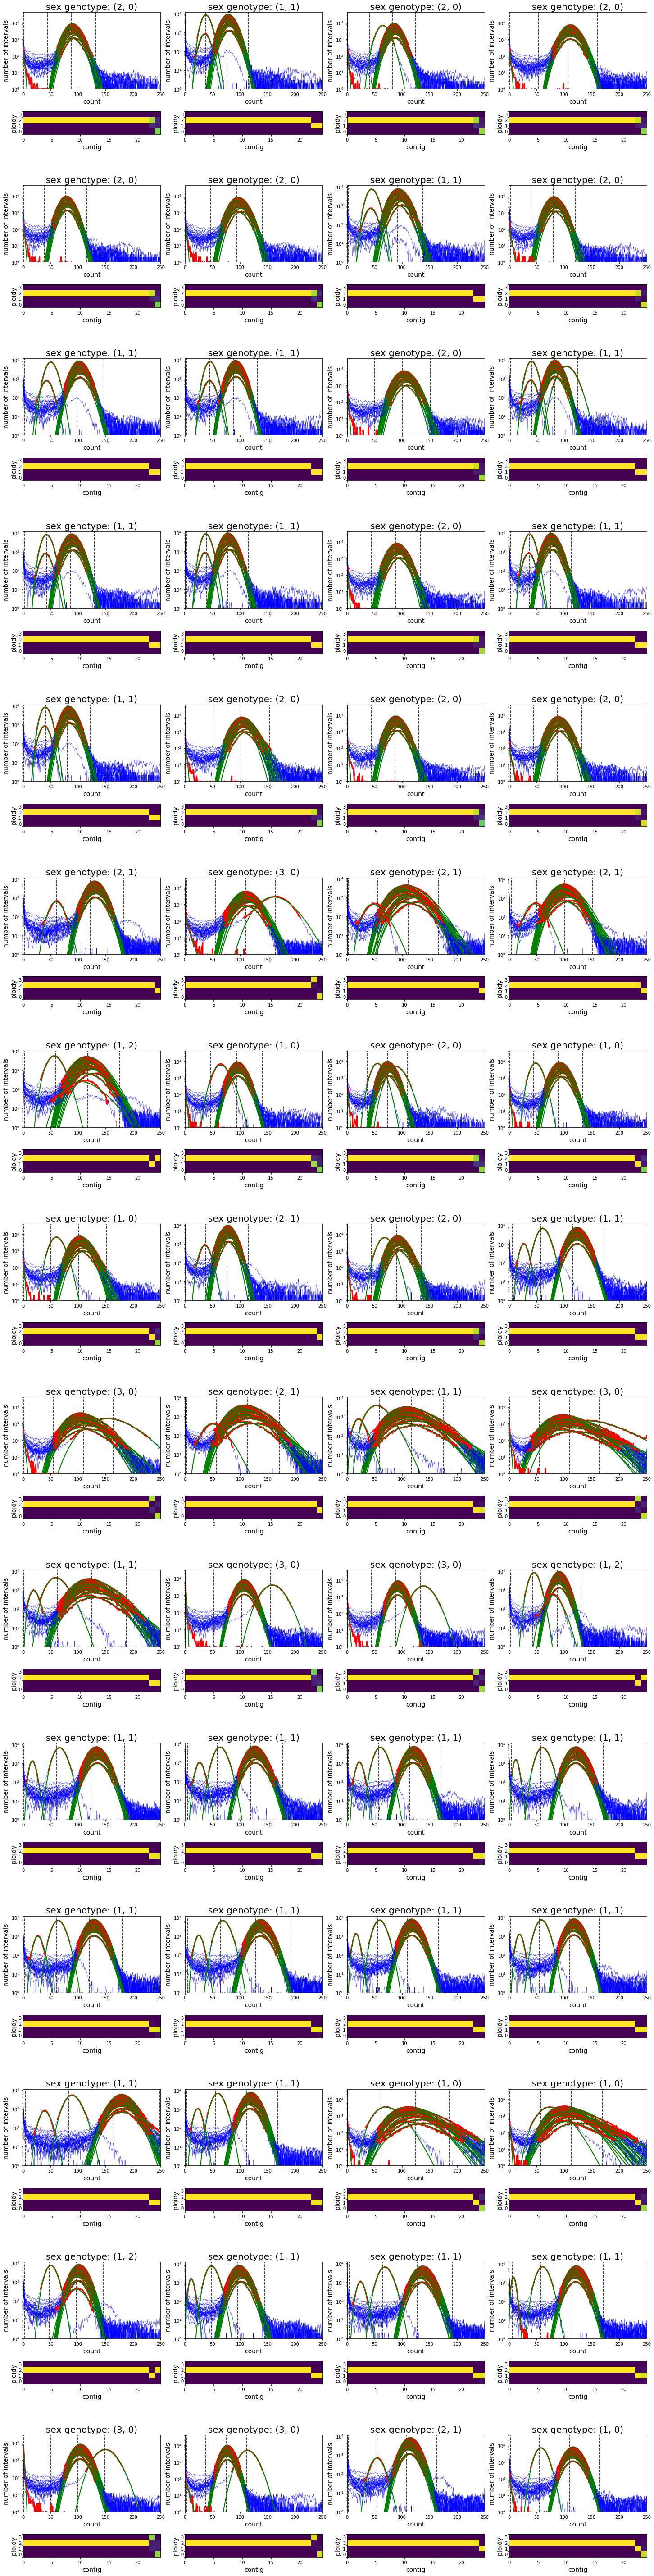

In [17]:
num_cols = 4
num_rows = 6 * (num_samples // num_cols)
fig = plt.figure(figsize=(20, 80))
for sample_index in range(num_samples):
    print('sample', sample_index, count_files[sample_index])
    fig_1_row = 6 * (sample_index // num_cols)
    fig_2_row = fig_1_row + 3
    col = sample_index % num_cols
    ax1 = plt.subplot2grid((num_rows, num_cols), (fig_1_row, col), rowspan=3)
    ax2 = plt.subplot2grid((num_rows, num_cols), (fig_2_row, col), rowspan=2)
                           
    for i, contig_set in enumerate(contig_sets):
        for contig_index in contig_set:
            d = d_s_tr[sample_index]
            b = b_j_tr[contig_index]
            f = f_js_tr[contig_index, sample_index]
            e = e_js_tr[contig_index, sample_index]
            alpha = alpha_js_tr[contig_index, sample_index]
            pi = pi_jsk_tr[contig_index][sample_index, :]
            n = ploidy_jk[contig_index][np.argmax(pi)]
            mu = d * b * np.maximum(n + f, e)
            var = mu + mu**2 / alpha
            n_nb, p_nb = convert_params(mu, var)
            hist_m_masked = hist_sjm[sample_index, contig_index][mask_sjm[sample_index, contig_index]]
            num_occurrences_tot = sum(hist_m_masked)
            ax1.semilogy(hist_sjm[sample_index, contig_index], color='b', lw=0.5)
            ax1.semilogy(count_states[mask_sjm[sample_index, contig_index]], hist_m_masked, color='r', lw=3)
            ax1.semilogy(num_occurrences_tot * nbinom(n=n_nb, p=p_nb).pmf(count_states), color='g', lw=2)
            y_max = 2 * np.max(hist_sjm[sample_index, contig_index])
            ax1.set_xlim([0, max_count])
            ax1.set_ylim([1, y_max])
    ax1.vlines(d * np.array([e, 1, 2, 3]), 1, y_max, linestyles='dashed')
    n_X = ploidy_jk[-2][np.argmax(pi_jsk_tr[-2][sample_index, :])]
    n_Y = ploidy_jk[-1][np.argmax(pi_jsk_tr[-1][sample_index, :])]
    ax1.set_title('sex genotype: ({0:d}, {1:d})'.format(n_X, n_Y), size=20)
    ax1.set_xlabel('count', size=14)
    ax1.set_ylabel('number of intervals', size=14)
    num_ploidy = np.max([np.max(ploidy_k) for ploidy_k in ploidy_jk]) + 1
    pi_jp = np.zeros((num_contigs, num_ploidy))
    for contig_index in range(num_contigs):
        for ploidy in range(num_ploidy):
            pi_jp[contig_index, ploidy] = np.sum(pi_jsk_tr[contig_index][sample_index][ploidy_jk[contig_index] == ploidy])
    ax2.imshow(np.transpose(pi_jp), origin='lower', extent=[0, num_contigs, 0, num_ploidy])
    ax2.set_yticks(np.arange(num_ploidy + 1))
    ax2.set_yticklabels([])
    ax2.set_yticks(np.arange(num_ploidy) + 0.5, minor=True)
    ax2.set_yticklabels(np.arange(num_ploidy), minor=True)
    ax2.tick_params(axis='y', length=0, which='minor')
    ax2.set_xlabel('contig', size=14)
    ax2.set_ylabel('ploidy', size=14)
plt.tight_layout(pad=0.1)
plt.savefig('prototype-result.png', dpi=300)
plt.savefig('prototype-result.pdf')
plt.savefig('prototype-result.eps')
plt.show()